In [1]:
#TENSORFLOW
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense
from keras.layers import add
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

#OTHER LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from tqdm.notebook import tqdm
import shutil
import io
import PIL
from keras import backend as K
import cv2
import json

tf.random.set_seed(123412)

TRAIN_PATH= './dataset/train'
TEST_PATH= './dataset/test'
MODELS_PATH = './models/'

BATCH_SIZE = 16
RESCALE_SIZE = (299, 299)

# Cargar datos y definir modelo

In [2]:
def f1_macro(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
train_generator = ImageDataGenerator(
    rescale=1/255.,         #normalize the images
    rotation_range=40,      #random rotation up to +-40 grades
    width_shift_range=0.2,  #random horizontal shift ratio
    height_shift_range=0.2, #random vertical shift ratio
    shear_range=0.2,        #random shear ratio
    zoom_range=0.2,         #random zoom ratio
    horizontal_flip=True,   #allow to randomly horizontal flip the images
    fill_mode='nearest',     #due to this transformations, to fill the gaps it follows some strategy
).flow_from_directory(
    TRAIN_PATH,
    target_size=RESCALE_SIZE, #scale all the images to same resolution
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

test_generator = ImageDataGenerator(
    rescale=1/255.
).flow_from_directory(
    TEST_PATH,
    target_size=RESCALE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 11200 images belonging to 8 classes.
Found 4800 images belonging to 8 classes.


## ResnetInceptionV2

In [4]:
# Define the model
inputs = tf.keras.Input(shape=(299, 299, 3))

x = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    input_shape=None,
)


x = tf.keras.layers.Flatten()(x.output)
outputs = tf.keras.layers.Dense(8, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='ResInceptionV2')



# model.summary()

# Train Model

In [8]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
exp = 'ResnetInceptionV2'


model_checkpoint = ModelCheckpoint(f'{MODELS_PATH}{exp}.ckpt', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=5, verbose=1)
callbacks=[reduce_lr, model_checkpoint]

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(amsgrad=True, learning_rate=4e-5
                #    , weight_decay=0.05
    ),
    metrics=[f1_macro, 'accuracy']
)

In [9]:
history = model.fit(
    train_generator,
    epochs=20,
    verbose=1,
    validation_data=test_generator,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
129/700 [====>.........................] - ETA: 2:22 - loss: 0.1280 - f1_macro: 0.9589 - accuracy: 0.9593

c:\Users\adrig\anaconda3\envs\tf\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


700/700 [==============================] - ETA: 0s - loss: 0.1483 - f1_macro: 0.9542 - accuracy: 0.9534
Epoch 1: val_accuracy improved from -inf to 0.93708, saving model to ./models\ResnetInceptionV2.ckpt
700/700 [==============================] - 214s 291ms/step - loss: 0.1483 - f1_macro: 0.9542 - accuracy: 0.9534 - val_loss: 0.2650 - val_f1_macro: 0.9372 - val_accuracy: 0.9371 - lr: 4.0000e-05
Epoch 2/20
700/700 [==============================] - ETA: 0s - loss: 0.1273 - f1_macro: 0.9613 - accuracy: 0.9615
Epoch 2: val_accuracy did not improve from 0.93708
700/700 [==============================] - 199s 283ms/step - loss: 0.1273 - f1_macro: 0.9613 - accuracy: 0.9615 - val_loss: 0.2551 - val_f1_macro: 0.9381 - val_accuracy: 0.9362 - lr: 4.0000e-05
Epoch 3/20
700/700 [==============================] - ETA: 0s - loss: 0.1275 - f1_macro: 0.9612 - accuracy: 0.9609
Epoch 3: val_accuracy did not improve from 0.93708
700/700 [==============================] - 200s 285ms/step - loss: 0.1275 -

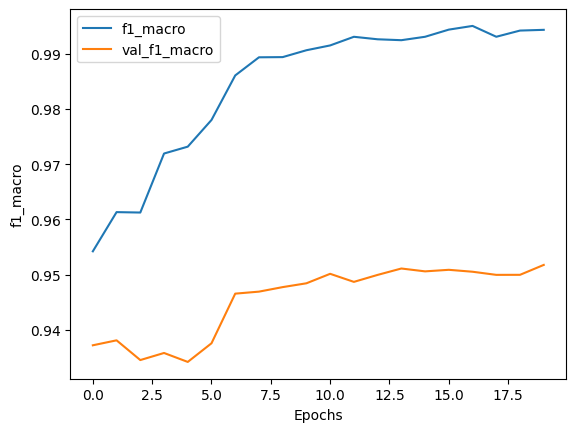

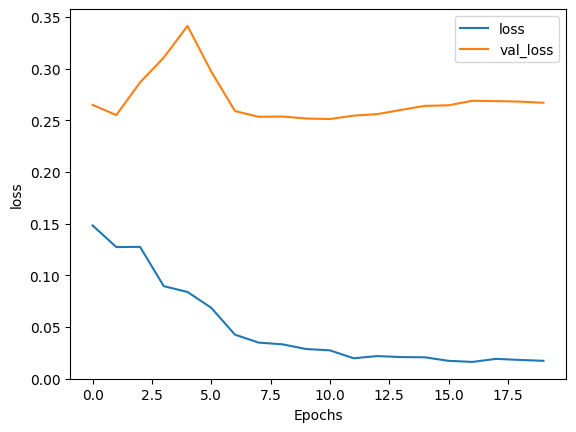

In [10]:
def plot_graphs(history, plot):
  plt.plot(history.history[plot])
  plt.plot(history.history['val_'+plot])
  plt.xlabel("Epochs")
  plt.ylabel(plot)
  plt.legend([plot, 'val_'+plot])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "f1_macro")
plot_graphs(history, "loss")

## Generate JSON

In [11]:
inputs = tf.keras.Input(shape=(299, 299, 3))

x = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    input_shape=None,
)


x = tf.keras.layers.Flatten()(x.output)
outputs = tf.keras.layers.Dense(8, activation=tf.nn.softmax)(x)
model_aux = tf.keras.Model(inputs=inputs, outputs=outputs, name='ResInceptionV2')

In [12]:
model_aux.load_weights(f'{MODELS_PATH}{exp}.ckpt')

In [13]:
test = pd.read_csv('./dataset/test.csv')
test.path_img = [f'./dataset/{path}' for path in test.path_img]

In [14]:
predicted_classes = {}

for idx, path in zip(test.idx_test, test.path_img):
    img = cv2.imread(path)
    img = cv2.resize(img, (299, 299))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model_aux.predict(img)
    label = np.argmax(pred)

    predicted_classes[str(idx)] = int(label)

1/1 [==============================] - 0s 39ms/step


In [15]:
with open(f'{MODELS_PATH}{exp}.json', 'w') as f:
    json.dump({'target': predicted_classes}, f)